In [2]:
%matplotlib inline


In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
def regression (xnot,ynot,xxx,yyy):
    yval = [] 
    xval = [] 
    totdays = len(xxx) -2
    if totdays-xnot>3:
        for days in range(0,totdays):
            xval.append(xxx[days])
            if yyy[days]!=0:
                ystr = yyy[days]
                yval.append(np.log(ystr/ynot))
            else:
                yval.append(1)
        (slope, intercept, r, a, b)=stats.linregress(xval, yval)
    else:
        slope = 0
        r=0
        intercept = 0
    return slope,r*r,intercept

In [5]:
def cleaning (dirty,var_cln):
    for st in states.index:
        hold = dirty[st]
        for cnt in hold:
            new_var = var_cln+'I'
            hold[cnt].update({new_var:[hold[cnt][var_cln][0]]})
            if len(hold[cnt][var_cln]) > 2:
                for x in np.arange(1,len(hold[cnt][var_cln])-1,1):
                    hold[cnt][new_var].append((hold[cnt][var_cln][x-1]+hold[cnt][var_cln][x]+hold[cnt][var_cln][x+1])/3)
                hold[cnt][new_var].append(hold[cnt][var_cln][x+1])


In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df = pd.DataFrame(data)
df.head()
dfar = df.loc[df['county']== 'New York City']
dfar.head()   

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
565,2020-03-05,New York City,New York,NaN,4,0


In [7]:
df['date'] = pd.to_datetime(df['date'])
states = df['state'].value_counts()

In [8]:
#Build raw data dictionary for county derivitive vs days
exponential={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    exponential.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        yprev = 0
        exponential[st].update({cnt:{}})
        exponential[st][cnt].update( {'xval' : []})
        exponential[st][cnt].update({'delta' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            dif = ycur - yprev
            exponential[st][cnt]['delta'].append(dif)
            exponential[st][cnt]['xval'].append(days)
            days=days+1
            yprev = ycur
        
    

In [9]:
cleaning(exponential,'delta')
cleaning(exponential,'deltaI')
cleaning(exponential,'deltaII')
cleaning(exponential,'deltaIII')
cleaning(exponential,'deltaIIII')
cleaning(exponential,'deltaIIIII')

In [10]:
#build raw data dictionary for county cases vs days
population={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    population.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        population[st].update({cnt:{}})
        population[st][cnt].update( {'xval' : []})
        population[st][cnt].update({'cases' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            population[st][cnt]['cases'].append(ycur)
            population[st][cnt]['xval'].append(days)
            days=days+1

In [11]:
cleaning(population, 'cases')   #data cleaning see box 4
cleaning(population, 'casesI')

In [12]:
#code for building a dictionary to be passed into a dataframe
direct_tau = {'State':[],'County':[],'Ynot':[],'First Doubling':[], 'Current Total':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'Days In':[],'int':[], 'ID':[]}
for st in states.index:
    test = population[st]  #pass each state dictionary into holding dictionary
    for cnt in test:
        day=0
        test2 = test[cnt]  #pass each county dictionary into holding dictionary
        start =test2['cases'][0]
        for x in np.arange(1, len(test2['casesII']),1):  #iterate through days to test for thresh hold
            if test2['casesII'][x]>=2*start:
                day = x
                start =test2['cases'][x]
                invtau,rr, inter = regression(day,start,test2['xval'],test2['casesII']) #regression analysis(see box 3)
                direct_tau['State'].append(st)
                direct_tau['County'].append(cnt)
                direct_tau['Ynot'].append(start)
                direct_tau['First Doubling'].append(day)
                direct_tau['Current Total'].append(test2['cases'][len(test2['cases'])-1])
                direct_tau['Inv Tau'].append(invtau)
                direct_tau['Days In'].append(len(test2['cases'])-1)
                direct_tau['int'].append(inter)
                if invtau != 0:
                    direct_tau['Tau'].append(1/invtau)
                else:
                    direct_tau['Tau'].append(0)
                direct_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                direct_tau['ID'].append(fips_hold['fips'][0])
                break

In [13]:
direct_df=pd.DataFrame(direct_tau)
direct_df = direct_df.sort_values('Inv Tau', ascending =False)
direct_df.to_csv('../output_data/county_metrics')
direct_df.head()

,State,County,Ynot,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,int,ID
1514,Iowa,Louisa,1,1,166,0.433381,2.307438,0.921579,12,0.804218,19115.0
2085,Nebraska,Custer,3,2,19,0.430050,2.325310,0.984377,9,-0.974096,31041.0
930,Kentucky,Adair,9,4,45,0.353767,2.826716,0.976082,10,-1.355515,21001.0
936,Kentucky,Whitley,1,2,7,0.347137,2.880704,0.978249,7,0.021594,21235.0
1275,Illinois,Coles,2,2,9,0.318040,3.144258,0.985378,8,-0.582471,17029.0


In [48]:
NC_direct = direct_df.loc[direct_df['State']=='North Carolina']
NC_direct.to_csv('../output_data/NCcounty_metrics')
NC_direct.head()

,State,County,Ynot,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,int,ID
509,North Carolina,Wake,1,5,501,0.144418,6.924326,0.971147,42,0.899940,37183.0
510,North Carolina,Chatham,3,12,75,0.118378,8.447544,0.940961,39,-1.564716,37037.0
511,North Carolina,Onslow,3,12,29,0.138074,7.242474,0.984082,33,-1.802276,37133.0
512,North Carolina,Cabarrus,2,9,190,0.153288,6.523683,0.907338,33,-0.245139,37025.0
513,North Carolina,Forsyth,7,8,121,0.131409,7.609828,0.961986,33,-0.858834,37067.0


In [49]:
county_tau = {'State':[],'County':[],'First Doubling':[], 'Last Delta':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'ID':[]}
for st in states.index:
    test = exponential[st]
    for cnt in test:
        day=0
        test2 = test[cnt]
        for x in np.arange(1, len(test2['deltaIII']),1):
            if test2['deltaIII'][x]>4:
                day = x
                invtau,rr = regression(day,test2['deltaIII'][x],test2['xval'],test2['deltaIII']) 
                county_tau['State'].append(st)
                county_tau['County'].append(cnt)
                county_tau['First Doubling'].append(day)
                county_tau['Last Delta'].append(test2['delta'][len(test2['delta'])-1])
                county_tau['Inv Tau'].append(invtau)
                if invtau != 0:
                    county_tau['Tau'].append(1/invtau)
                else:
                    county_tau['Tau'].append(0)
                county_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                county_tau['ID'].append(fips_hold['fips'][0])
                break


ValueError: too many values to unpack (expected 2)

In [16]:
deriv_df=pd.DataFrame(county_tau)
deriv_df=deriv_df.sort_values('Inv Tau', ascending =False)
deriv_df.to_csv('../output_data/derivitivedata')
deriv_df.head()


,State,County,First Doubling,Last Delta,Inv Tau,Tau,R Squared,ID
516,Iowa,Louisa,3,70,0.292979,3.413215,0.889232,19115.0
657,New Jersey,Union,7,629,0.229464,4.357973,0.859099,34039.0
654,New Jersey,Passaic,9,488,0.228986,4.367086,0.870551,34031.0
396,New York,New York City,7,3701,0.228973,4.367333,0.833007,NaN
443,Pennsylvania,Luzerne,8,77,0.224058,4.463132,0.838860,42079.0


In [17]:
NC_deriv = deriv_df.loc[deriv_df['State']=='North Carolina']
NC_deriv.to_csv('../output_data/NCderivitivedata')

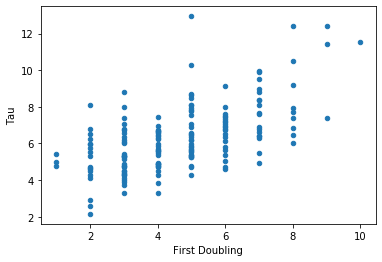

In [17]:
hold_df = direct_df.loc[direct_df['R Squared']>.98]
hold_df.plot('First Doubling','Tau', kind ='scatter')
# plt.xlim(0,500)
# plt.ylim(0,40)

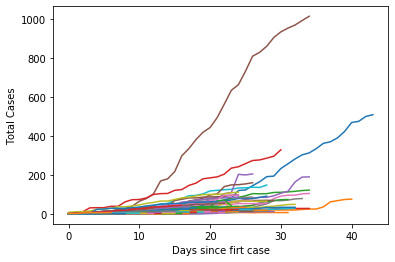

<Figure size 432x288 with 0 Axes>

In [18]:
state = 'North Carolina'
test =population[state]
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['cases'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.show()
plt.savefig(f'../output_data/{state}_raw.png')

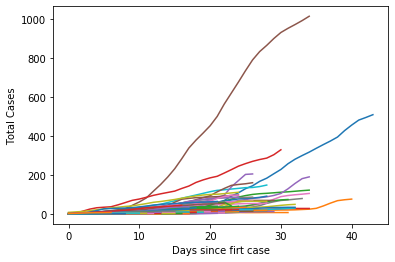

In [19]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesI'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.savefig(f'../output_data/{state}_clnI.png')
plt.show()

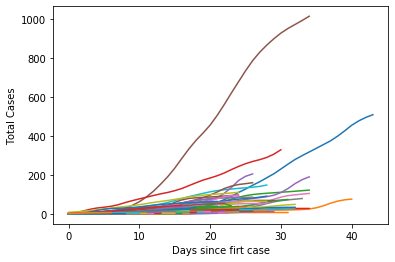

In [20]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesII'])
plt.xlabel('Days since firt case')
plt.ylabel('Total Cases')
plt.savefig(f'../output_data/{state}_clnII.png')
plt.show()

Wake County
   index           State County  Ynot  First Doubling  Current Total  \
0    514  North Carolina   Wake     1               5            510   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.158661  6.302762    0.95781       43  0.461473  37183.0  


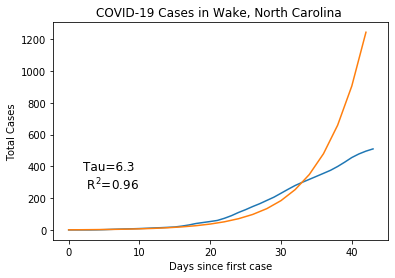

Chatham County
   index           State   County  Ynot  First Doubling  Current Total  \
0    515  North Carolina  Chatham     3              12             77   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.120449  8.302287   0.962166       40 -1.638574  37037.0  


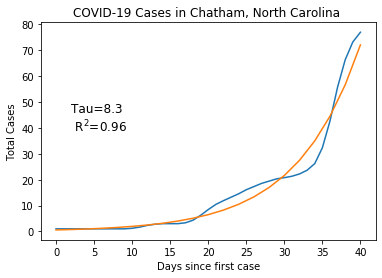

Forsyth County
   index           State   County  Ynot  First Doubling  Current Total  \
0    516  North Carolina  Forsyth     7               8            123   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.152551  6.555176   0.955725       34 -1.393379  37067.0  


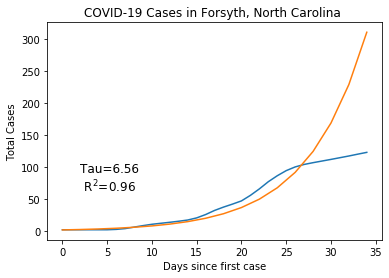

Onslow County
   index           State  County  Ynot  First Doubling  Current Total  \
0    517  North Carolina  Onslow     3              12             29   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.130688  7.651793   0.960121       34 -1.693454  37133.0  


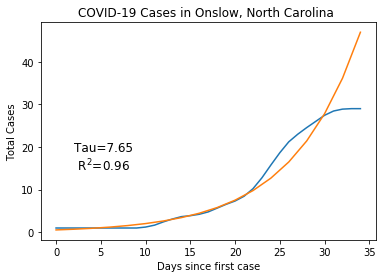

Cabarrus County
   index           State    County  Ynot  First Doubling  Current Total  \
0    518  North Carolina  Cabarrus     2               9            191   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.183989  5.435115   0.943283       34 -1.003709  37025.0  


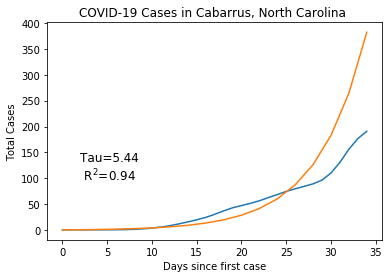

Mecklenburg County
   index           State       County  Ynot  First Doubling  Current Total  \
0    519  North Carolina  Mecklenburg     4               4           1015   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.202893  4.928714   0.893284       34  0.165849  37119.0  


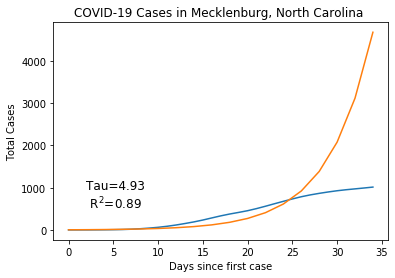

Johnston County
   index           State    County  Ynot  First Doubling  Current Total  \
0    520  North Carolina  Johnston     2               4            106   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.148694  6.725237   0.986324       34 -0.796315  37101.0  


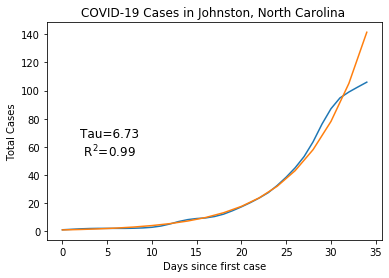

Wayne County
   index           State County  Ynot  First Doubling  Current Total  \
0    521  North Carolina  Wayne     1              13             80   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.159107  6.285087   0.923686       33 -0.916569  37191.0  


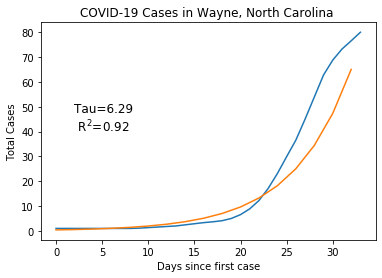

Harnett County
   index           State   County  Ynot  First Doubling  Current Total  \
0    522  North Carolina  Harnett     4               4             50   

   Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.09873  10.128596   0.964649       32 -0.334448  37085.0  


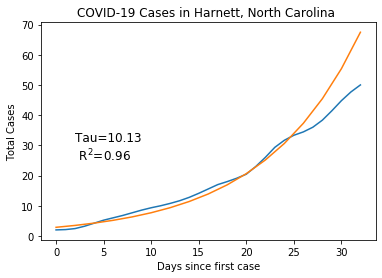

Craven County
   index           State  County  Ynot  First Doubling  Current Total  \
0    523  North Carolina  Craven     2               8             31   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.125151  7.990335   0.988289       32 -0.974525  37049.0  


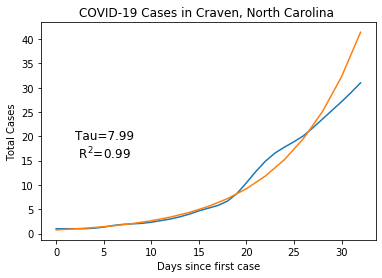

Brunswick County
   index           State     County  Ynot  First Doubling  Current Total  \
0    524  North Carolina  Brunswick     2               5             35   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.122973  8.131838   0.910222       32 -0.318863  37019.0  


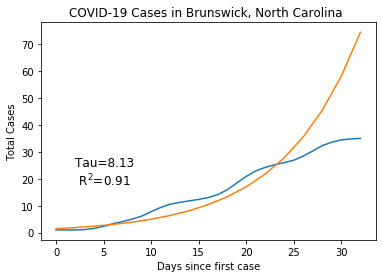

Watauga County
   index           State   County  Ynot  First Doubling  Current Total  \
0    525  North Carolina  Watauga     2               6              8   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.077844  12.846138   0.917416       31 -0.474012  37189.0  


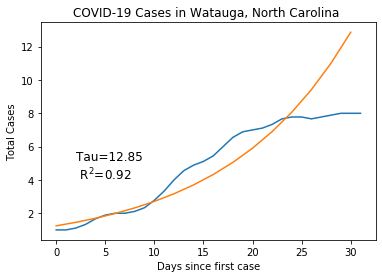

Wilson County
   index           State  County  Ynot  First Doubling  Current Total  \
0    526  North Carolina  Wilson     2               6             75   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.155827  6.417366   0.989786       31 -0.74222  37195.0  


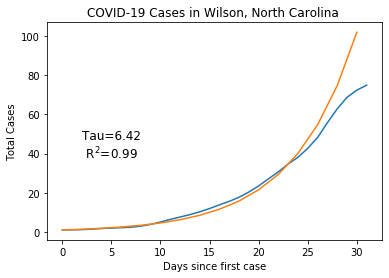

Durham County
   index           State  County  Ynot  First Doubling  Current Total  \
0    527  North Carolina  Durham     1               1            330   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.130694  7.651465   0.774752       30  2.569937  37063.0  


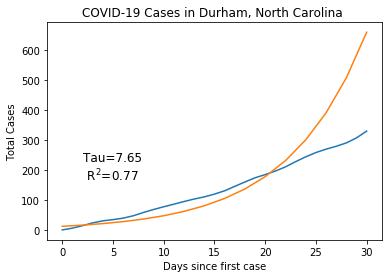

Sampson County
   index           State   County  Ynot  First Doubling  Current Total  \
0    528  North Carolina  Sampson     2              19             13   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.096409  10.372459   0.726282       29 -1.361023  37163.0  


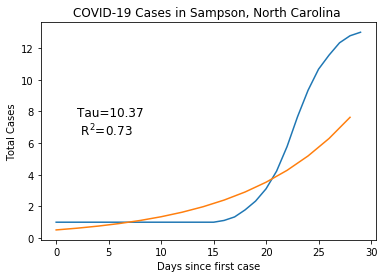

Iredell County
   index           State   County  Ynot  First Doubling  Current Total  \
0    529  North Carolina  Iredell     2               3             70   

    Inv Tau      Tau  R Squared  Days In       int       ID  
0  0.151416  6.60432   0.912988       29  0.095354  37097.0  


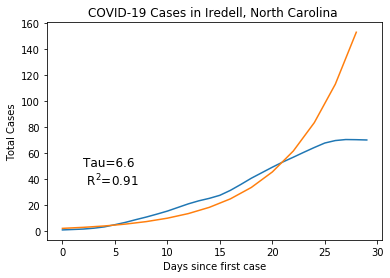

New Hanover County
   index           State       County  Ynot  First Doubling  Current Total  \
0    530  North Carolina  New Hanover     3               4             56   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.155426  6.433928    0.85273       28 -0.372217  37129.0  


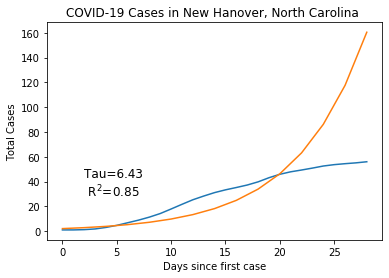

Lincoln County
   index           State   County  Ynot  First Doubling  Current Total  \
0    531  North Carolina  Lincoln     3              11             15   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.134954  7.409914   0.922794       28 -1.569539  37109.0  


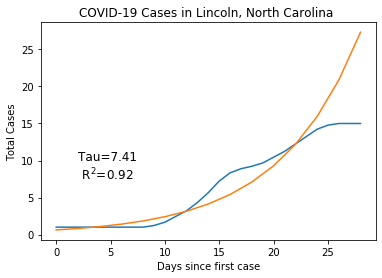

Moore County
   index           State County  Ynot  First Doubling  Current Total  \
0    532  North Carolina  Moore     2               3             66   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.162439  6.156143   0.944603       28 -0.832302  37125.0  


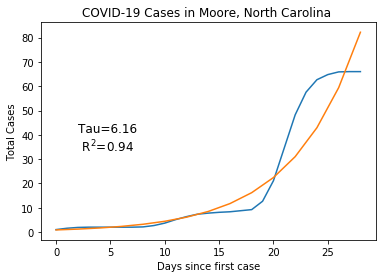

Guilford County
   index           State    County  Ynot  First Doubling  Current Total  \
0    533  North Carolina  Guilford     2               1            149   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.160058  6.247738   0.868591       28  0.802871  37081.0  


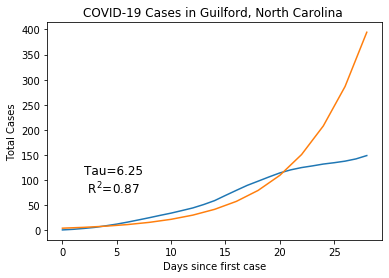

Gaston County
   index           State  County  Ynot  First Doubling  Current Total  \
0    534  North Carolina  Gaston     3               4             92   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.181894  5.497703   0.927819       28 -0.72177  37071.0  


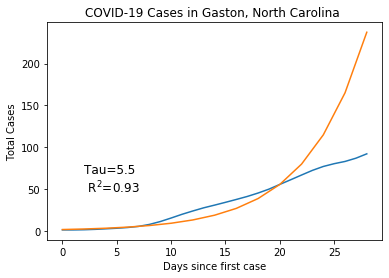

Hoke County
   index           State County  Ynot  First Doubling  Current Total  Inv Tau  \
0    535  North Carolina   Hoke     2               8             20  0.13255   

        Tau  R Squared  Days In       int       ID  
0  7.544331   0.981323       28 -0.946288  37093.0  


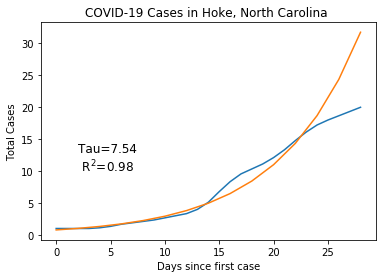

Pasquotank County
   index           State      County  Ynot  First Doubling  Current Total  \
0    536  North Carolina  Pasquotank     2              10             15   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.140326  7.126251   0.937128       26 -1.091175  37139.0  


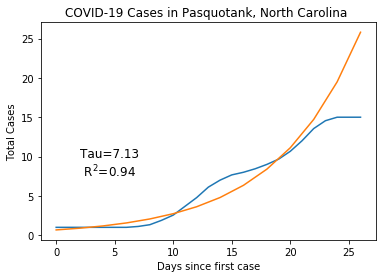

Stanly County
   index           State  County  Ynot  First Doubling  Current Total  \
0    537  North Carolina  Stanly     2               7             17   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.128329  7.792444   0.944752       26 -0.839436  37167.0  


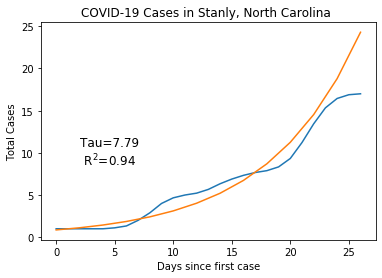

Rowan County
   index           State County  Ynot  First Doubling  Current Total  \
0    538  North Carolina  Rowan     2               2            206   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.193643  5.164153   0.957549       26 -0.028691  37159.0  


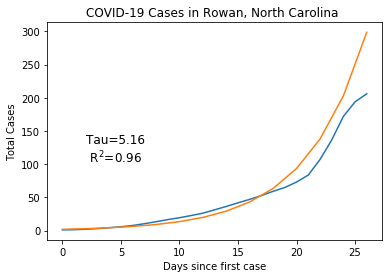

Orange County
   index           State  County  Ynot  First Doubling  Current Total  \
0    539  North Carolina  Orange     6               3            161   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.149464  6.690557   0.951076       26 -0.117541  37135.0  


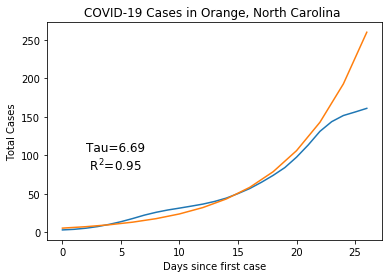

Pitt County
   index           State County  Ynot  First Doubling  Current Total  \
0    540  North Carolina   Pitt     3               2             69   

    Inv Tau      Tau  R Squared  Days In       int       ID  
0  0.158295  6.31732   0.908715       26 -0.153407  37147.0  


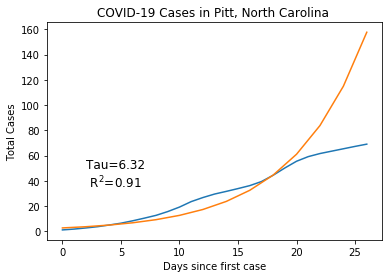

Davidson County
   index           State    County  Ynot  First Doubling  Current Total  \
0    541  North Carolina  Davidson     2               4             87   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.207704  4.814532   0.914006       26 -0.360801  37057.0  


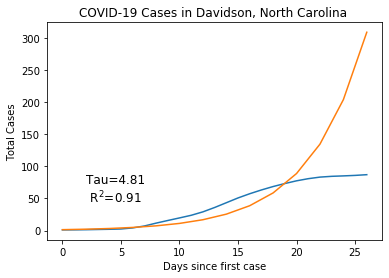

Franklin County
   index           State    County  Ynot  First Doubling  Current Total  \
0    542  North Carolina  Franklin    11              11             66   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.112042  8.925262   0.948823       26 -1.36806  37069.0  


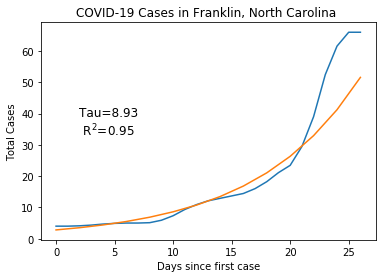

Carteret County
   index           State    County  Ynot  First Doubling  Current Total  \
0    543  North Carolina  Carteret     2               2             22   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.110955  9.012677   0.883403       26  0.144397  37031.0  


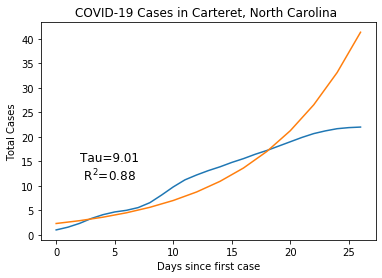

Buncombe County
   index           State    County  Ynot  First Doubling  Current Total  \
0    544  North Carolina  Buncombe     1               2             37   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.119037  8.400761   0.707861       25  1.428513  37021.0  


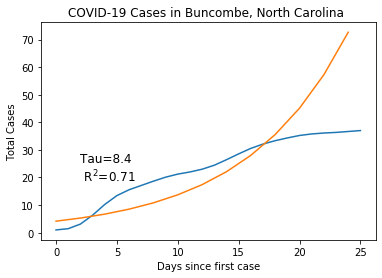

Catawba County
   index           State   County  Ynot  First Doubling  Current Total  \
0    545  North Carolina  Catawba     1               2             35   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.137738  7.260166   0.862623       25  0.851932  37035.0  


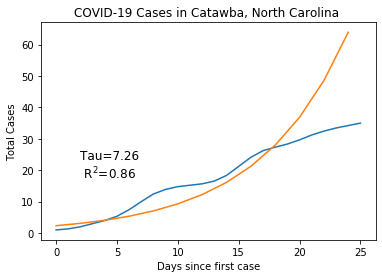

Nash County
   index           State County  Ynot  First Doubling  Current Total  \
0    546  North Carolina   Nash     2               5             40   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.180513  5.539761   0.953083       24 -0.597346  37127.0  


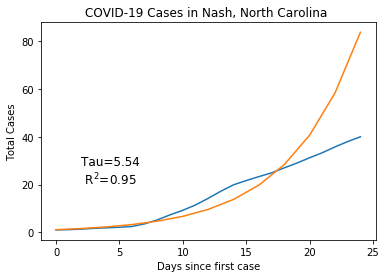

Davie County
   index           State County  Ynot  First Doubling  Current Total  \
0    547  North Carolina  Davie     2               5             22   

    Inv Tau      Tau  R Squared  Days In       int       ID  
0  0.156254  6.39983   0.846508       24 -0.397796  37059.0  


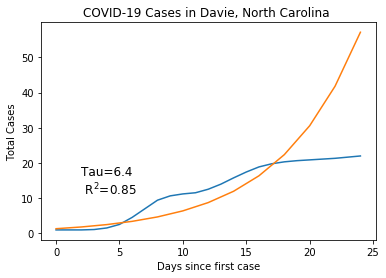

Cumberland County
   index           State      County  Ynot  First Doubling  Current Total  \
0    548  North Carolina  Cumberland     5               3             87   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.173857  5.751844   0.953464       24 -0.476557  37051.0  


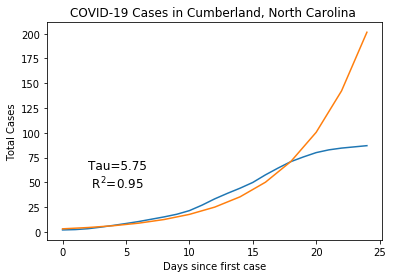

Granville County
   index           State     County  Ynot  First Doubling  Current Total  \
0    549  North Carolina  Granville     3               5             98   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.245165  4.078884   0.958781       24 -1.181913  37077.0  


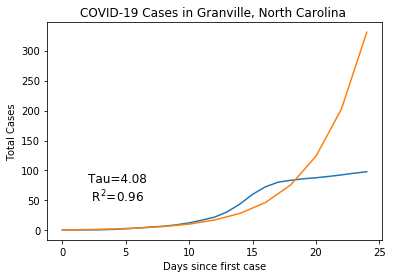

Henderson County
   index           State     County  Ynot  First Doubling  Current Total  \
0    550  North Carolina  Henderson     2               3             97   

   Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.19328  5.173842   0.926379       24  0.007667  37089.0  


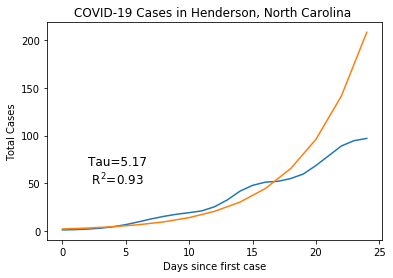

Scotland County
   index           State    County  Ynot  First Doubling  Current Total  \
0    551  North Carolina  Scotland     2               9              9   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.097801  10.224802   0.904472       24 -0.974608  37165.0  


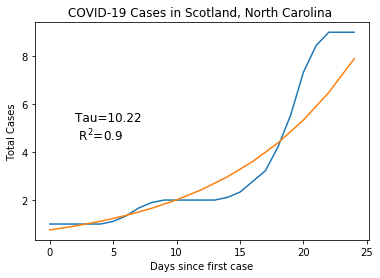

Union County
   index           State County  Ynot  First Doubling  Current Total  \
0    552  North Carolina  Union    24               4            112   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.106541  9.386059   0.933603       24 -0.541936  37179.0  


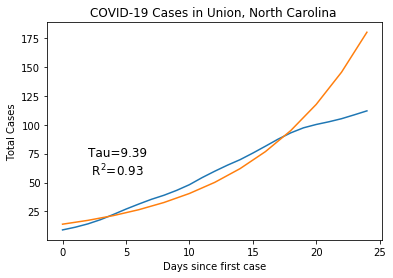

Robeson County
   index           State   County  Ynot  First Doubling  Current Total  \
0    553  North Carolina  Robeson     2               5             11   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.096183  10.396887   0.986908       24 -0.581767  37155.0  


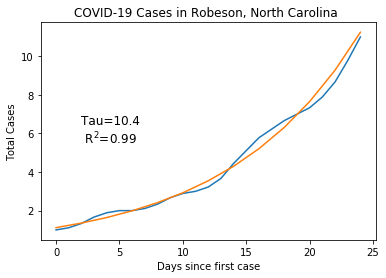

Lee County
   index           State County  Ynot  First Doubling  Current Total  \
0    554  North Carolina    Lee     2               7             16   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.106538  9.386362   0.947787       24 -0.831334  37105.0  


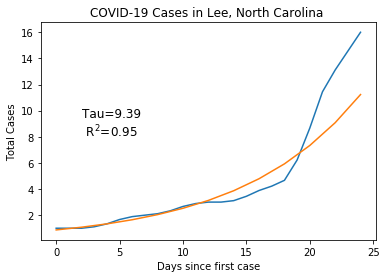

Cherokee County
   index           State    County  Ynot  First Doubling  Current Total  \
0    555  North Carolina  Cherokee     8              11             12   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.050355  19.859168   0.903226       24 -0.720945  37039.0  


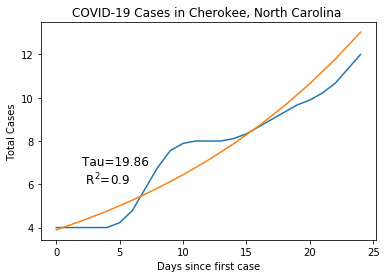

Alamance County
   index           State    County  Ynot  First Doubling  Current Total  \
0    556  North Carolina  Alamance     6               6             42   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.142317  7.026562   0.996095       23 -0.811502  37001.0  


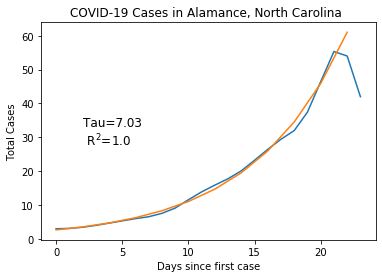

Vance County
   index           State County  Ynot  First Doubling  Current Total  \
0    557  North Carolina  Vance     2               3             23   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.143823  6.952998   0.976886       23 -0.41091  37181.0  


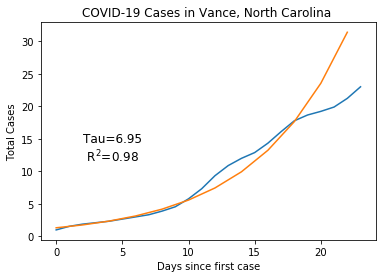

Montgomery County
   index           State      County  Ynot  First Doubling  Current Total  \
0    558  North Carolina  Montgomery     3               2             15   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.111962  8.931611   0.880252       22 -0.432532  37123.0  


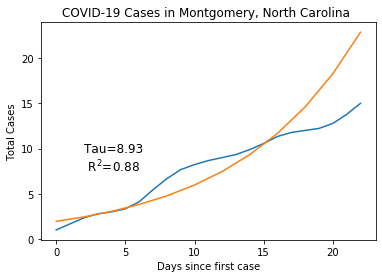

Randolph County
   index           State    County  Ynot  First Doubling  Current Total  \
0    559  North Carolina  Randolph     3               2             56   

   Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.14754  6.777826   0.893558       22  0.321526  37151.0  


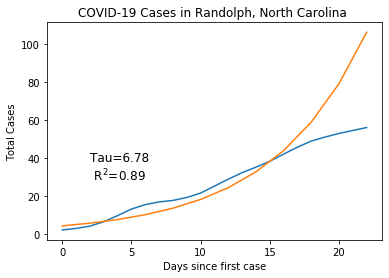

Transylvania County
   index           State        County  Ynot  First Doubling  Current Total  \
0    560  North Carolina  Transylvania     2               2              6   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.072756  13.744562   0.777452       22 -0.038429  37175.0  


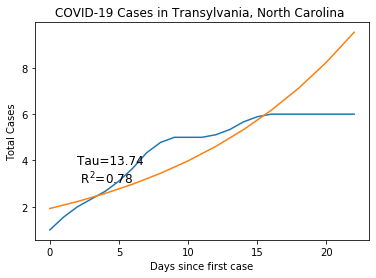

Burke County
   index           State County  Ynot  First Doubling  Current Total  \
0    561  North Carolina  Burke     5               5             59   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.204467  4.890755   0.989945       21 -1.093021  37023.0  


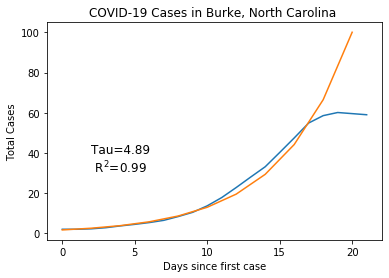

Bertie County
   index           State  County  Ynot  First Doubling  Current Total  \
0    562  North Carolina  Bertie     5               5             16   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.093197  10.730003   0.962744       21 -0.663531  37015.0  


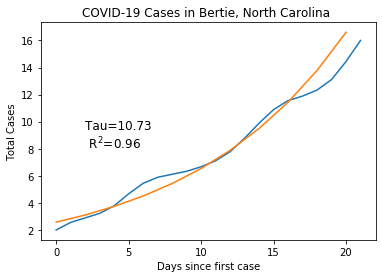

McDowell County
   index           State    County  Ynot  First Doubling  Current Total  \
0    563  North Carolina  McDowell     4               4             18   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.109116  9.164584   0.952778       21 -0.446904  37111.0  


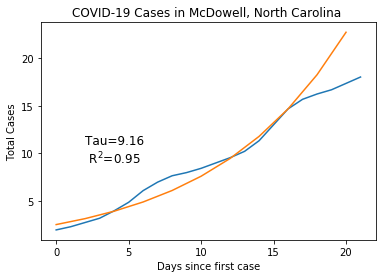

Northampton County
   index           State       County  Ynot  First Doubling  Current Total  \
0    564  North Carolina  Northampton     3               1             65   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.163078  6.132018   0.711105       21  0.554231  37131.0  


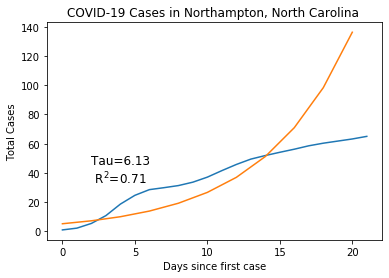

Lenoir County
   index           State  County  Ynot  First Doubling  Current Total  \
0    565  North Carolina  Lenoir     3               1             14   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.126041  7.933912   0.943775       21 -0.610819  37107.0  


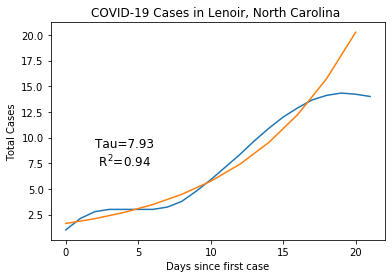

Cleveland County
   index           State     County  Ynot  First Doubling  Current Total  \
0    566  North Carolina  Cleveland     2               2             40   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.182704  5.473342   0.962987       21 -0.126924  37045.0  


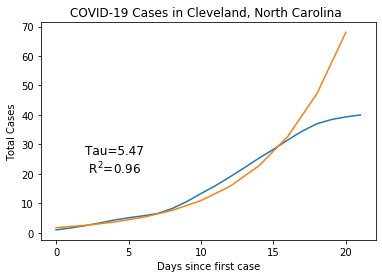

Duplin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    567  North Carolina  Duplin     2               8             18   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.178573  5.599941   0.951938       21 -1.206896  37061.0  


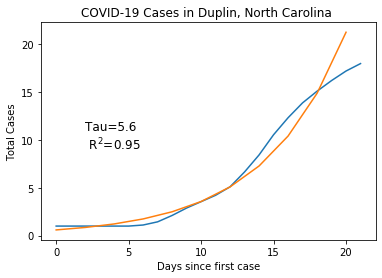

Hertford County
   index           State    County  Ynot  First Doubling  Current Total  \
0    568  North Carolina  Hertford     2               3              5   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.057563  17.372171    0.66846       21 -0.090533  37091.0  


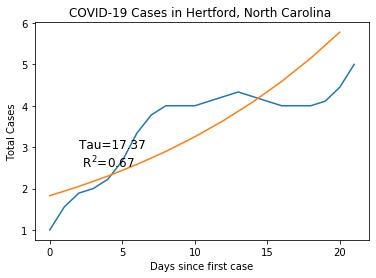

Caldwell County
   index           State    County  Ynot  First Doubling  Current Total  \
0    569  North Carolina  Caldwell     3               1             19   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.133268  7.503682   0.941302       21 -0.691131  37027.0  


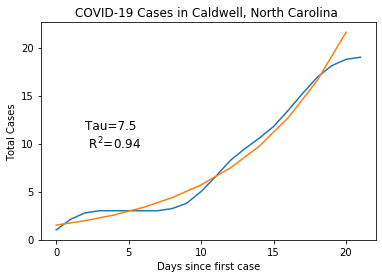

Beaufort County
   index           State    County  Ynot  First Doubling  Current Total  \
0    570  North Carolina  Beaufort     4               5             13   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.104044  9.611312   0.955734       20 -0.474998  37013.0  


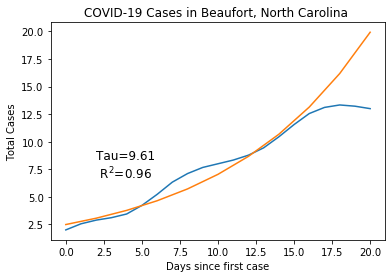

Person County
   index           State  County  Ynot  First Doubling  Current Total  \
0    571  North Carolina  Person     2               6             11   

    Inv Tau     Tau  R Squared  Days In       int       ID  
0  0.150591  6.6405    0.95829       19 -0.757125  37145.0  


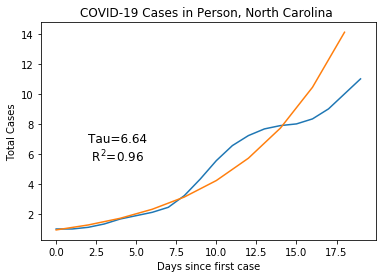

Greene County
   index           State  County  Ynot  First Doubling  Current Total  \
0    572  North Carolina  Greene     6               9             13   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.093821  10.658617   0.933414       19 -0.842647  37079.0  


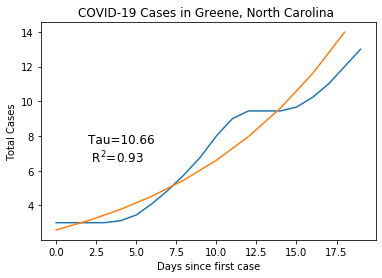

Surry County
   index           State County  Ynot  First Doubling  Current Total  \
0    573  North Carolina  Surry     2               4             10   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.150076  6.663275   0.936277       19 -0.62764  37171.0  


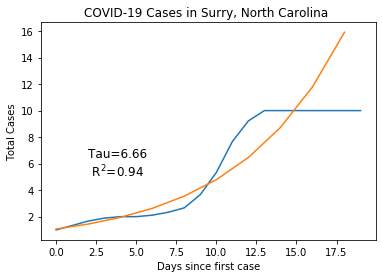

Edgecombe County
   index           State     County  Ynot  First Doubling  Current Total  \
0    574  North Carolina  Edgecombe     3               3             33   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.206619  4.839833   0.989406       18 -0.949498  37065.0  


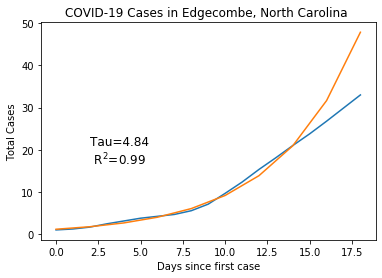

Richmond County
   index           State    County  Ynot  First Doubling  Current Total  \
0    575  North Carolina  Richmond     2              12             12   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.143382  6.974385   0.694783       18 -1.282661  37153.0  


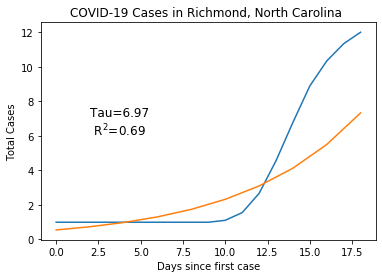

Perquimans County
   index           State      County  Ynot  First Doubling  Current Total  \
0    576  North Carolina  Perquimans     2              10              8   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.108091  9.251471     0.9188       18 -1.006023  37143.0  


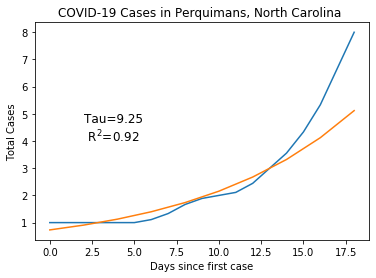

Polk County
   index           State County  Ynot  First Doubling  Current Total  \
0    577  North Carolina   Polk     4               5              9   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.099262  10.074342   0.889112       18 -0.502786  37149.0  


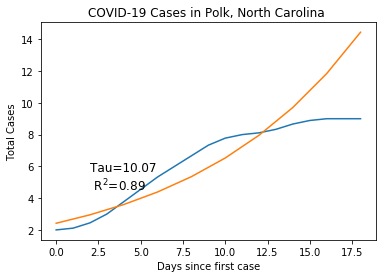

Columbus County
   index           State    County  Ynot  First Doubling  Current Total  \
0    578  North Carolina  Columbus     2               3             37   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.249995  4.000085   0.981062       17 -0.641453  37047.0  


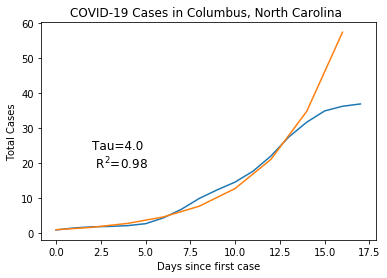

Caswell County
   index           State   County  Ynot  First Doubling  Current Total  \
0    579  North Carolina  Caswell     2               9              3   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.090794  11.013909   0.949905       17 -0.869952  37033.0  


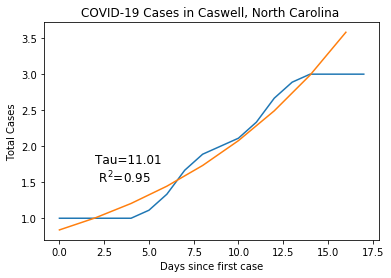

Alleghany County
   index           State     County  Ynot  First Doubling  Current Total  \
0    580  North Carolina  Alleghany     2               3              2   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.021019  47.57561   0.310246       17 -0.220245  37005.0  


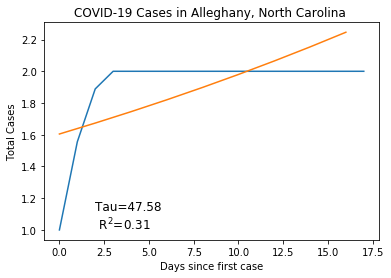

Pamlico County
   index           State   County  Ynot  First Doubling  Current Total  \
0    581  North Carolina  Pamlico     2               5              6   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.124628  8.023869   0.945981       17 -0.754825  37137.0  


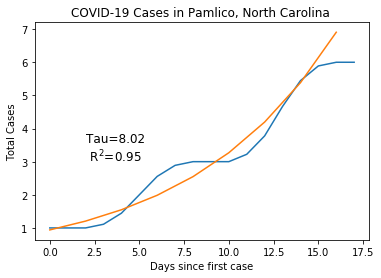

Washington County
   index           State      County  Ynot  First Doubling  Current Total  \
0    582  North Carolina  Washington     2               4             18   

   Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.19815  5.046694   0.988643       17 -0.64058  37187.0  


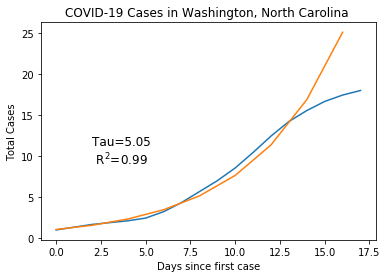

Yadkin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    583  North Carolina  Yadkin     3               2             11   

   Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.13295  7.521646   0.804949       17 -0.355605  37197.0  


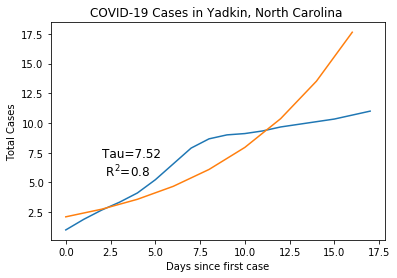

Halifax County
   index           State   County  Ynot  First Doubling  Current Total  \
0    584  North Carolina  Halifax     4               3             25   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.151336  6.607828   0.948626       17 -0.350463  37083.0  


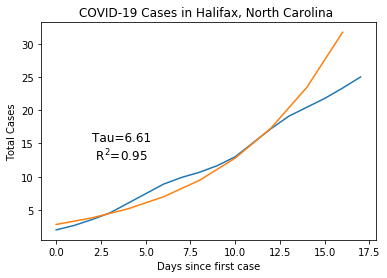

Currituck County
   index           State     County  Ynot  First Doubling  Current Total  \
0    585  North Carolina  Currituck     2               6              2   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.081796  12.225547   0.895103       17 -0.598833  37053.0  


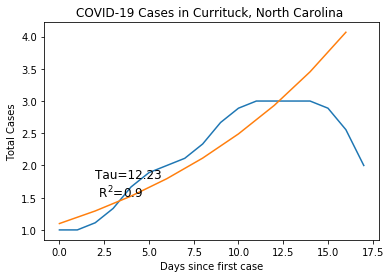

Alexander County
   index           State     County  Ynot  First Doubling  Current Total  \
0    586  North Carolina  Alexander     2               3              3   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.028747  34.786208   0.435271       16 -0.254123  37003.0  


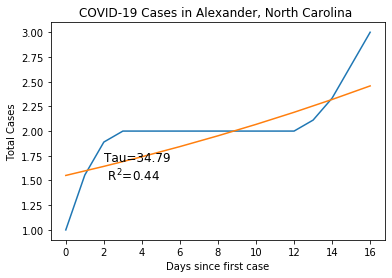

Rutherford County
   index           State      County  Ynot  First Doubling  Current Total  \
0    587  North Carolina  Rutherford     5               1             45   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.204731  4.884457   0.843601       16 -0.397742  37161.0  


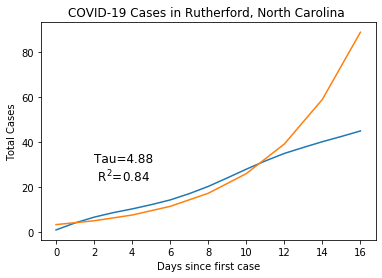

Anson County
   index           State County  Ynot  First Doubling  Current Total  \
0    588  North Carolina  Anson     3               3             12   

    Inv Tau       Tau  R Squared  Days In      int       ID  
0  0.184639  5.415967   0.925797       15 -0.80312  37007.0  


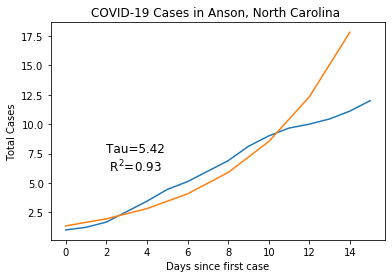

Wilkes County
   index           State  County  Ynot  First Doubling  Current Total  \
0    589  North Carolina  Wilkes     4               4              4   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.034092  29.332069    0.47775       15 -0.317178  37193.0  


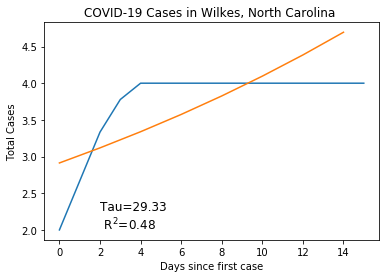

Martin County
   index           State  County  Ynot  First Doubling  Current Total  \
0    590  North Carolina  Martin     4               8              7   

   Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.08129  12.30158   0.989097       15 -0.631062  37117.0  


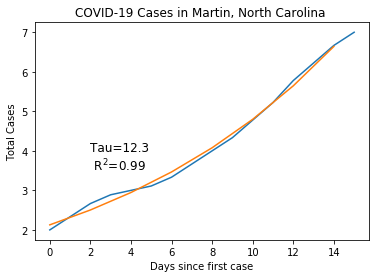

Rockingham County
   index           State      County  Ynot  First Doubling  Current Total  \
0    591  North Carolina  Rockingham     2               2             15   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.188399  5.307891   0.923632       15 -0.178358  37157.0  


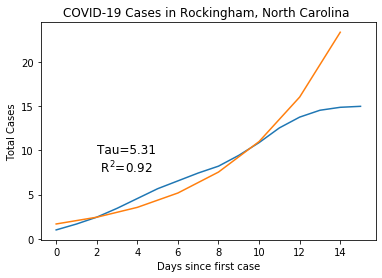

Clay County
   index           State County  Ynot  First Doubling  Current Total  \
0    592  North Carolina   Clay     2               2              3   

    Inv Tau        Tau  R Squared  Days In       int       ID  
0  0.063488  15.750988   0.559818       15 -0.158067  37043.0  


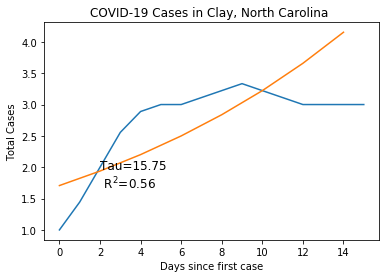

Macon County
   index           State County  Ynot  First Doubling  Current Total  Inv Tau  \
0    593  North Carolina  Macon     2               9              2      0.0   

   Tau  R Squared  Days In  int       ID  
0  0.0        0.0       13  0.0  37113.0  


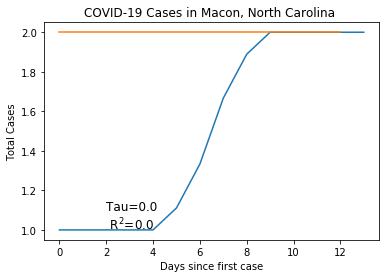

Gates County
   index           State County  Ynot  First Doubling  Current Total  \
0    594  North Carolina  Gates     2               5              4   

    Inv Tau       Tau  R Squared  Days In       int       ID  
0  0.163321  6.122915   0.908446       13 -0.835855  37073.0  


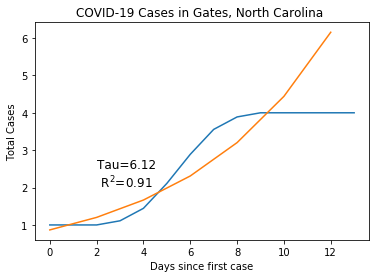

Bladen County
Empty DataFrame
Columns: [index, State, County, Ynot, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, int, ID]
Index: []


IndexError: index out of bounds

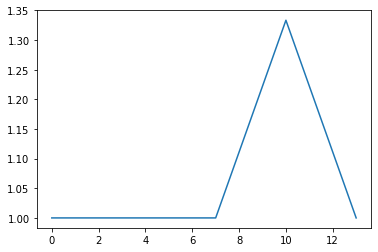

In [21]:
y=0
for x in test:
    print(f'{x} County')
    y=y+1
    df4 = direct_df.loc[(direct_df['County']==x)&(direct_df['State']==state)]
    df4 = df4.reset_index()
    print(df4)
    plt.plot(test[x]['xval'],test[x]['casesII'])
    invtau=df4['Inv Tau'][0]
    ynot = df4['Ynot'][0]
    xnot = df4['First Doubling'][0]
    xval = np.arange(0,len(test[x]['xval']),2)
    yval = ynot*np.exp((xval)*invtau+df4['int'][0])
    plt.plot(xval,yval)
    rsqr=df4['R Squared'][0]
    tau=df4['Tau'][0]
    plt.annotate(f'Tau={round(tau,2)}\n R$^2$={round(rsqr,2)}',(2,max(test[x]['casesII'])/2)).set_fontsize(12)
    plt.title(f'COVID-19 Cases in {x}, {state} ')
    plt.xlabel('Days since first case')
    plt.ylabel('Total Cases')
#     plt.savefig(f'../output_data/countyspreadimages/{y}_{x}{state}.png')
    plt.show()

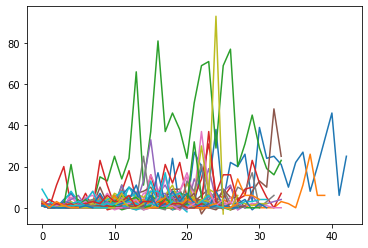

In [23]:
test = exponential[state]
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['delta'])
plt.show()

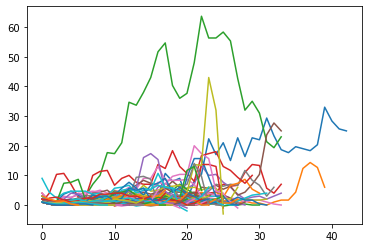

In [24]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaI'])
plt.show()

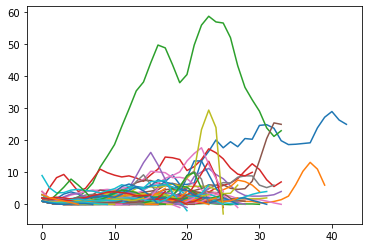

In [25]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaII'])
plt.show()

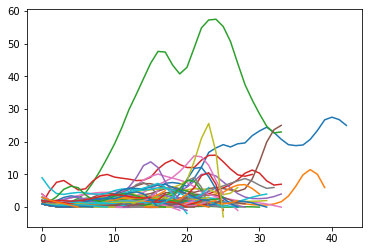

In [26]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaIII'])
plt.show()

Wake County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
162  North Carolina   Wake              16          25  0.114852  8.706845   

     R Squared       ID  
162   0.876873  37183.0  


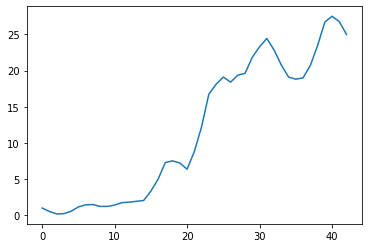

Chatham County
              State   County  First Doubling  Last Delta  Inv Tau  Tau  \
163  North Carolina  Chatham              35           6      0.0  0.0   

     R Squared       ID  
163        0.0  37037.0  


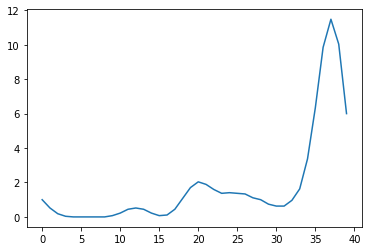

Mecklenburg County
              State       County  First Doubling  Last Delta   Inv Tau  \
164  North Carolina  Mecklenburg               6          23  0.116375   

         Tau  R Squared       ID  
164  8.59293   0.652283  37119.0  


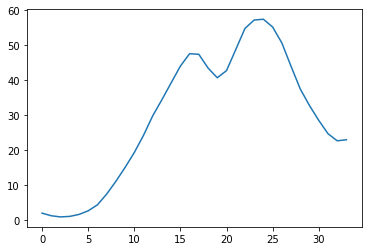

Johnston County
              State    County  First Doubling  Last Delta   Inv Tau       Tau  \
165  North Carolina  Johnston              23           7  0.132428  7.551281   

     R Squared       ID  
165   0.590134  37101.0  


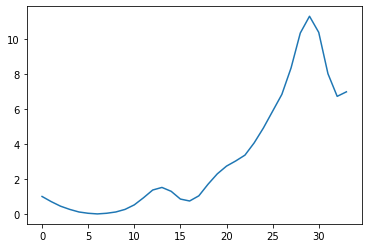

Forsyth County
              State   County  First Doubling  Last Delta   Inv Tau        Tau  \
166  North Carolina  Forsyth              16           4  0.072727  13.750103   

     R Squared       ID  
166   0.343853  37067.0  


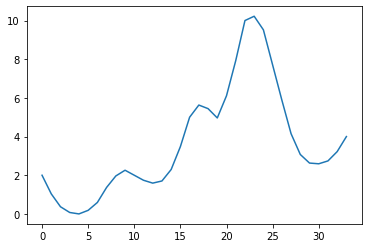

Cabarrus County
              State    County  First Doubling  Last Delta   Inv Tau       Tau  \
167  North Carolina  Cabarrus              15          25  0.130882  7.640458   

     R Squared       ID  
167   0.570194  37025.0  


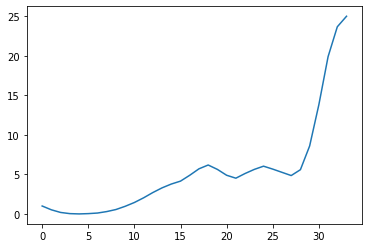

Onslow County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


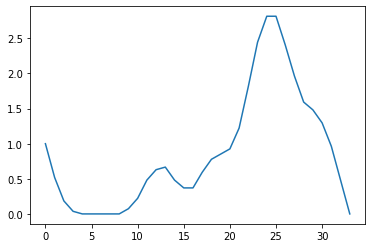

Wayne County
              State County  First Doubling  Last Delta   Inv Tau        Tau  \
168  North Carolina  Wayne              23           6  0.090156  11.091899   

     R Squared       ID  
168   0.202873  37191.0  


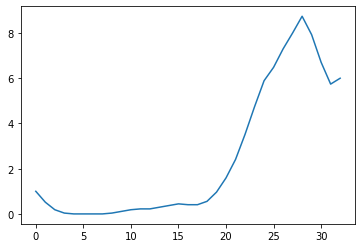

Craven County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


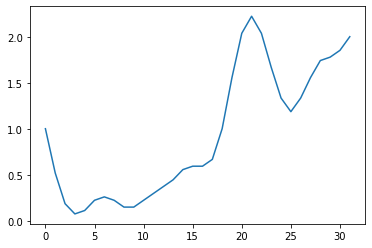

Harnett County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


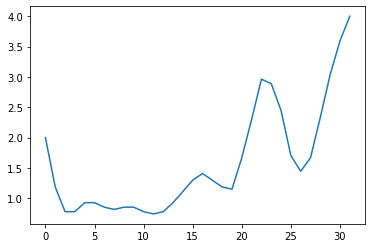

Brunswick County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


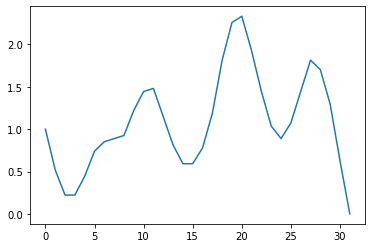

Wilson County
              State  County  First Doubling  Last Delta   Inv Tau      Tau  \
169  North Carolina  Wilson              25           4  0.117014  8.54596   

     R Squared       ID  
169   0.864197  37195.0  


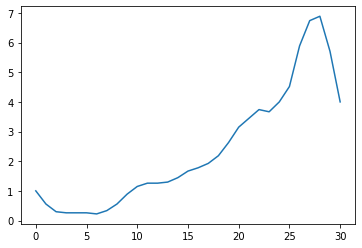

Watauga County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


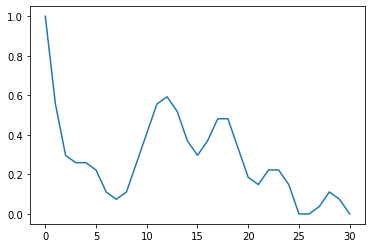

Durham County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
170  North Carolina  Durham               1          10  0.047398  21.097891   

     R Squared       ID  
170   0.526492  37063.0  


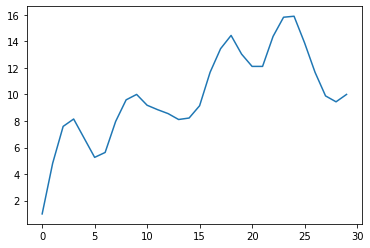

Sampson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


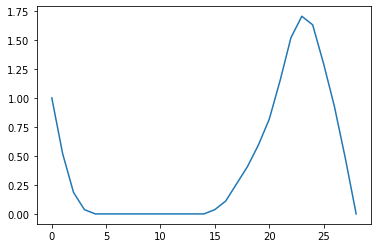

Iredell County
              State   County  First Doubling  Last Delta   Inv Tau        Tau  \
171  North Carolina  Iredell              17           1  0.061599  16.233971   

     R Squared       ID  
171   0.684219  37097.0  


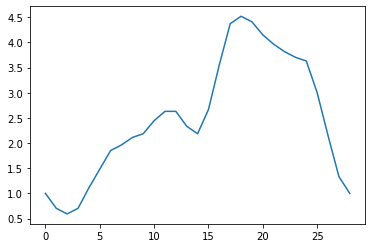

Guilford County
              State    County  First Doubling  Last Delta   Inv Tau  \
172  North Carolina  Guilford               7          -1  0.046145   

           Tau  R Squared       ID  
172  21.670634   0.326928  37081.0  


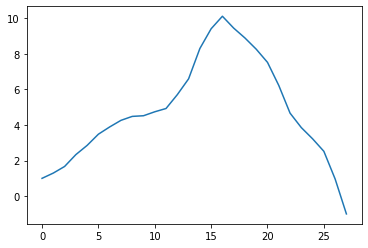

New Hanover County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


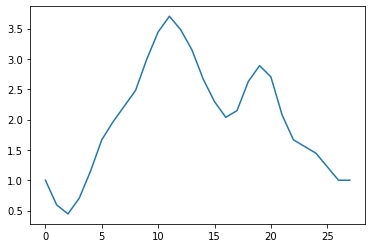

Gaston County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
173  North Carolina  Gaston              10           6  0.096712  10.339978   

     R Squared       ID  
173   0.734295  37071.0  


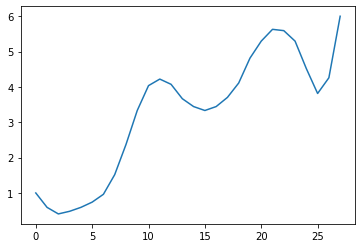

Lincoln County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


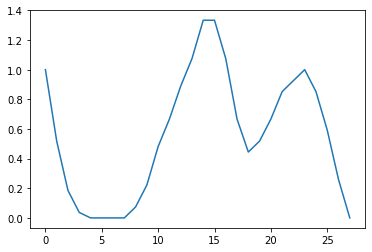

Moore County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
174  North Carolina  Moore              19           0  0.116207  8.605301   

     R Squared       ID  
174   0.273748  37125.0  


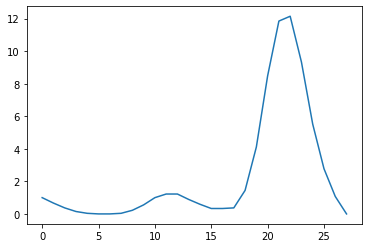

Hoke County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


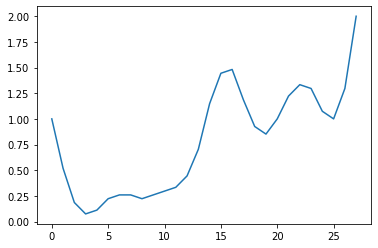

Pitt County
              State County  First Doubling  Last Delta  Inv Tau        Tau  \
175  North Carolina   Pitt              18           3  0.05804  17.229361   

     R Squared       ID  
175   0.617968  37147.0  


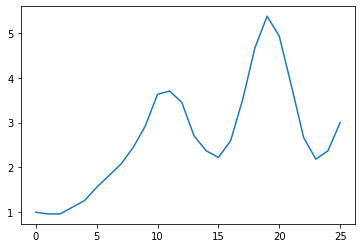

Franklin County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
176  North Carolina  Franklin              21          -1      0.0  0.0   

     R Squared       ID  
176        0.0  37069.0  


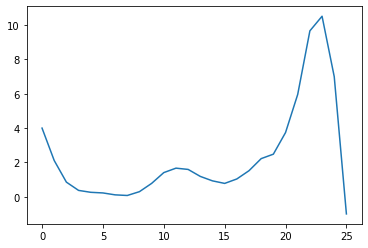

Carteret County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


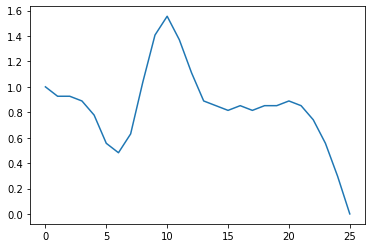

Davidson County
              State    County  First Doubling  Last Delta   Inv Tau  \
177  North Carolina  Davidson               9           2  0.092465   

           Tau  R Squared       ID  
177  10.814859   0.424667  37057.0  


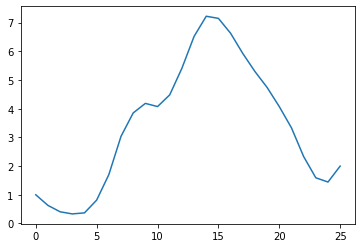

Orange County
              State  County  First Doubling  Last Delta   Inv Tau        Tau  \
178  North Carolina  Orange               7           4  0.084579  11.823216   

     R Squared       ID  
178   0.801905  37135.0  


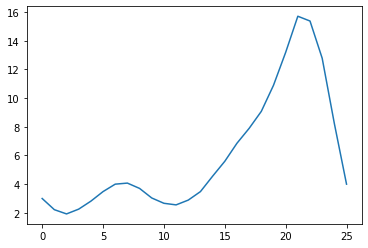

Pasquotank County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


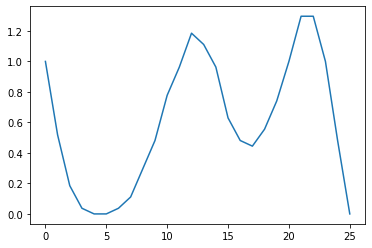

Rowan County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
179  North Carolina  Rowan              13          -3  0.131064  7.629842   

     R Squared       ID  
179   0.946633  37159.0  


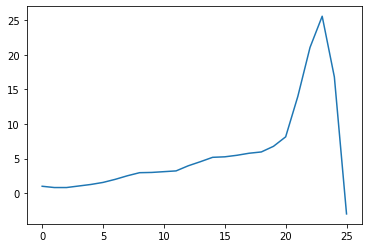

Stanly County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


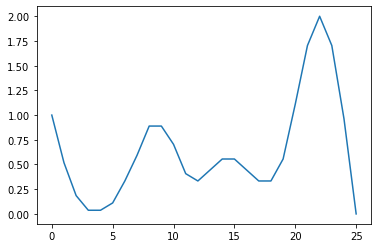

Buncombe County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


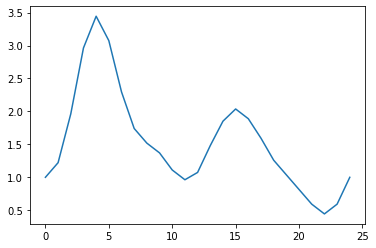

Catawba County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


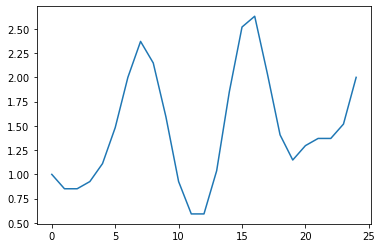

Robeson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


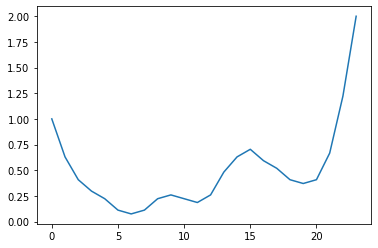

Davie County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


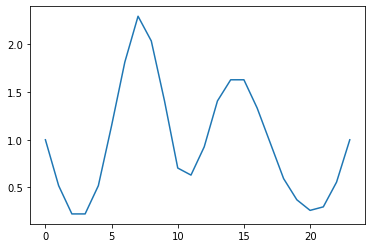

Granville County
              State     County  First Doubling  Last Delta   Inv Tau  \
180  North Carolina  Granville              11           5  0.131319   

          Tau  R Squared       ID  
180  7.615022   0.525743  37077.0  


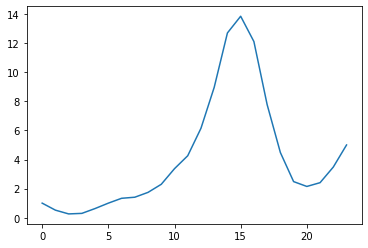

Lee County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


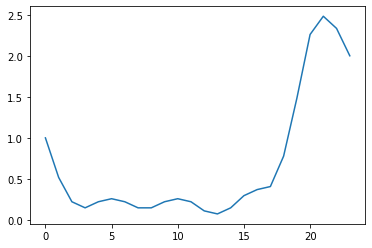

Cherokee County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


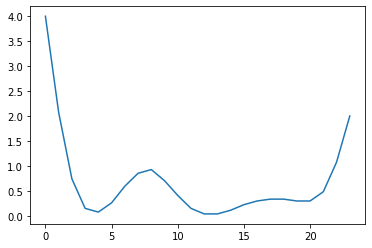

Henderson County
              State     County  First Doubling  Last Delta   Inv Tau  \
181  North Carolina  Henderson              12           0  0.096817   

           Tau  R Squared       ID  
181  10.328761   0.709024  37089.0  


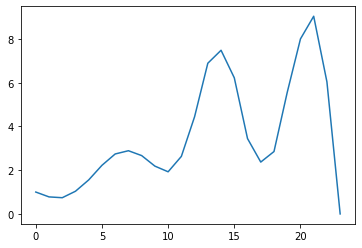

Nash County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


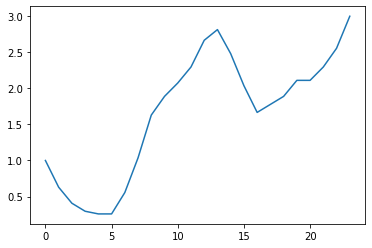

Union County
              State County  First Doubling  Last Delta   Inv Tau         Tau  \
182  North Carolina  Union               1           6 -0.009783 -102.216977   

     R Squared       ID  
182   0.068784  37179.0  


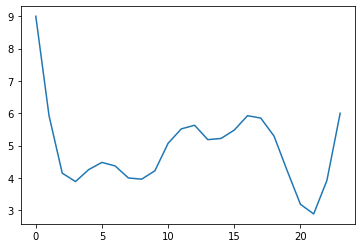

Cumberland County
              State      County  First Doubling  Last Delta   Inv Tau  \
183  North Carolina  Cumberland              11           2  0.072189   

           Tau  R Squared       ID  
183  13.852515   0.672309  37051.0  


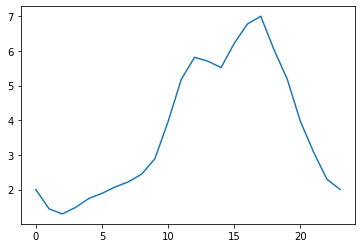

Scotland County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


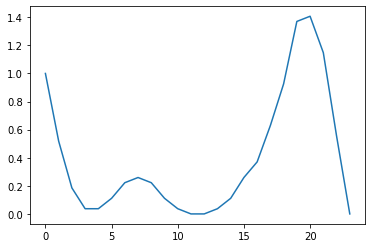

Alamance County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
184  North Carolina  Alamance              19           5      0.0  0.0   

     R Squared       ID  
184        0.0  37001.0  


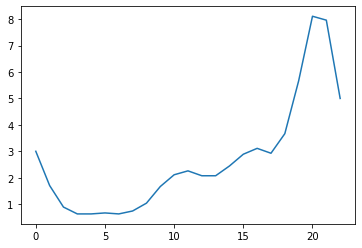

Vance County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


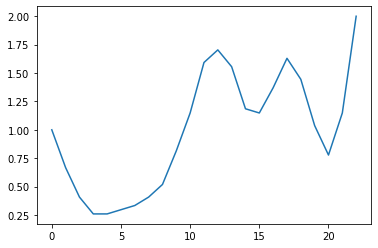

Randolph County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


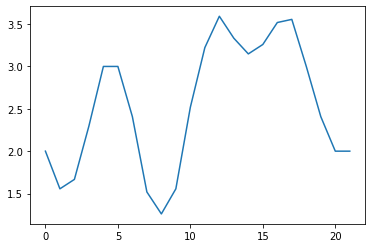

Transylvania County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


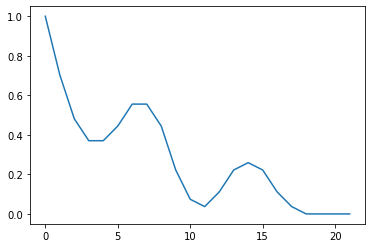

Montgomery County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


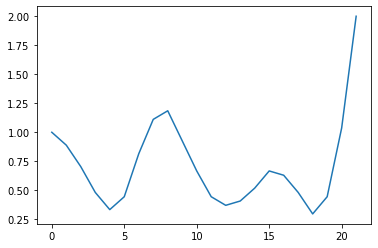

Hertford County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


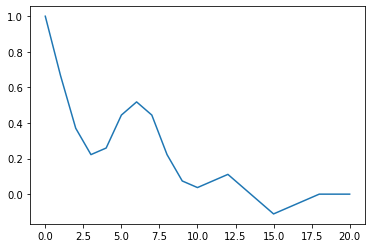

Cleveland County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


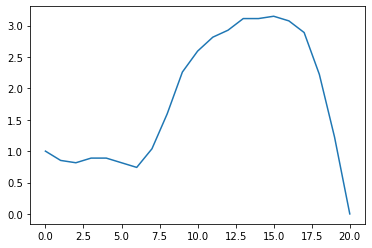

Burke County
              State County  First Doubling  Last Delta   Inv Tau       Tau  \
185  North Carolina  Burke              11          -2  0.133996  7.462902   

     R Squared       ID  
185   0.754989  37023.0  


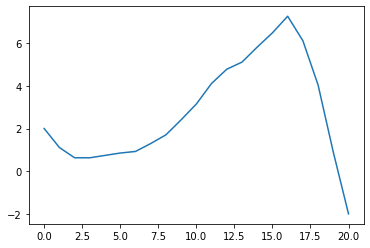

McDowell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


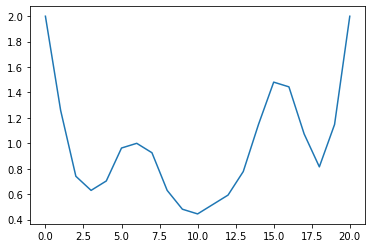

Duplin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


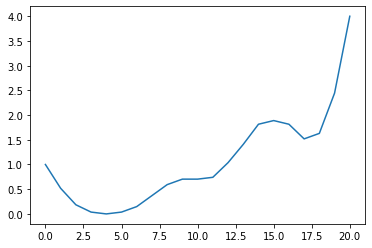

Northampton County
              State       County  First Doubling  Last Delta   Inv Tau  \
186  North Carolina  Northampton               3           2 -0.007758   

            Tau  R Squared       ID  
186 -128.898414   0.008356  37131.0  


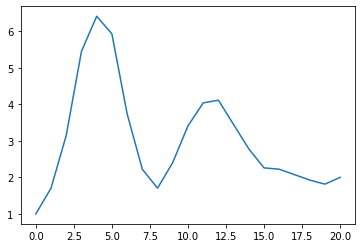

Caldwell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


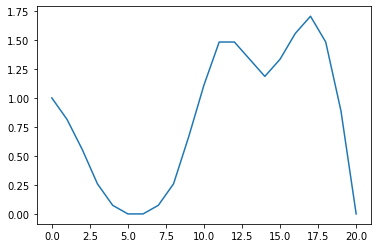

Lenoir County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


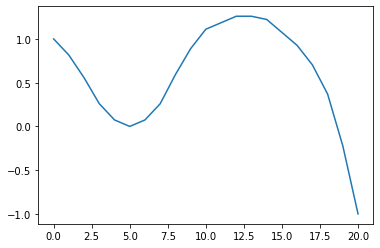

Bertie County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


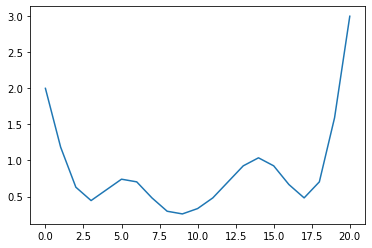

Beaufort County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


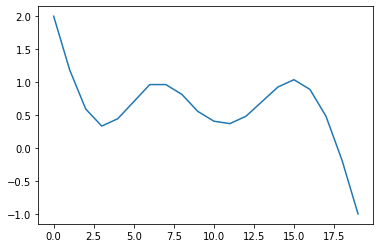

Person County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


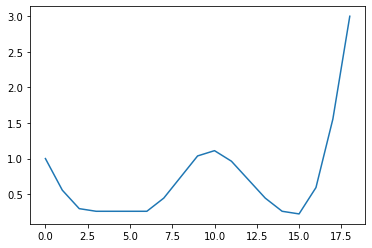

Surry County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


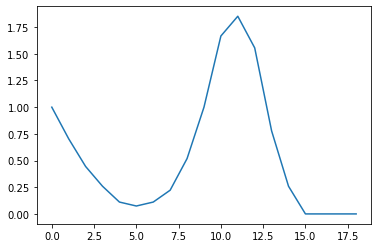

Greene County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


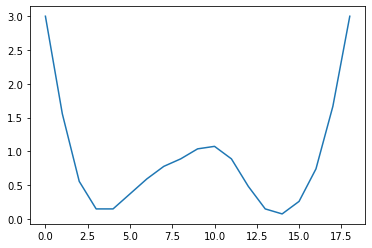

Richmond County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


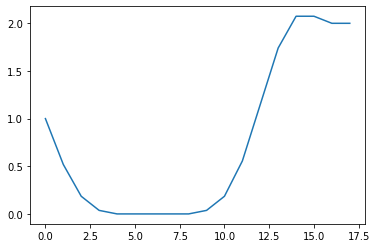

Edgecombe County
              State     County  First Doubling  Last Delta  Inv Tau  Tau  \
187  North Carolina  Edgecombe              17           5      0.0  0.0   

     R Squared       ID  
187        0.0  37065.0  


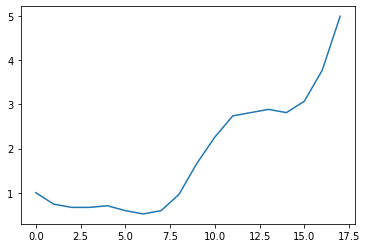

Polk County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


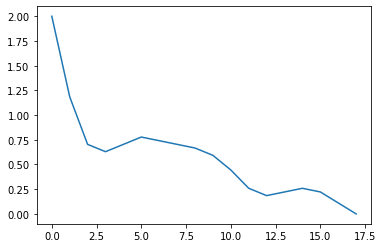

Perquimans County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


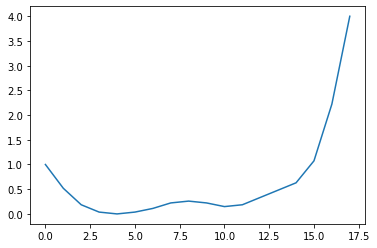

Alleghany County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


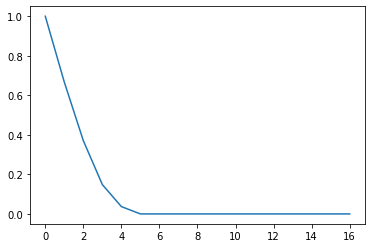

Currituck County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


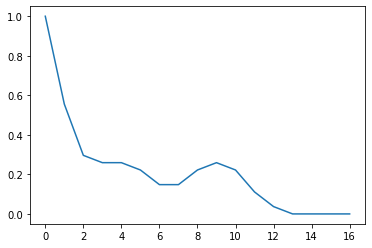

Halifax County
              State   County  First Doubling  Last Delta  Inv Tau  Tau  \
188  North Carolina  Halifax              16           5      0.0  0.0   

     R Squared       ID  
188        0.0  37083.0  


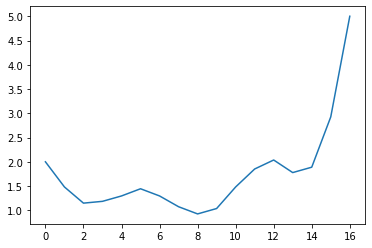

Pamlico County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


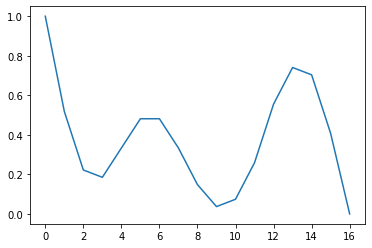

Yadkin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


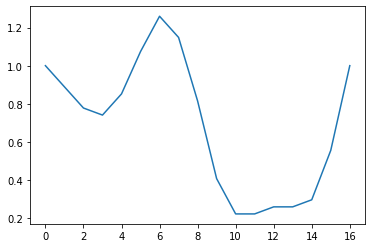

Washington County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


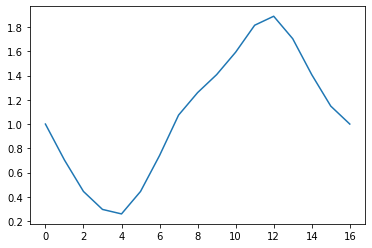

Columbus County
              State    County  First Doubling  Last Delta  Inv Tau  Tau  \
189  North Carolina  Columbus              12           0      0.0  0.0   

     R Squared       ID  
189        0.0  37047.0  


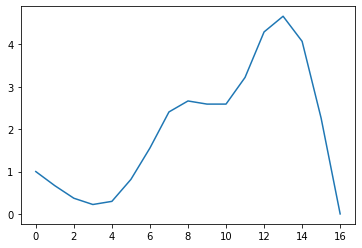

Caswell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


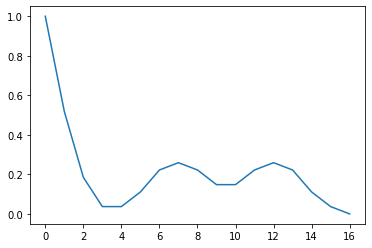

Alexander County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


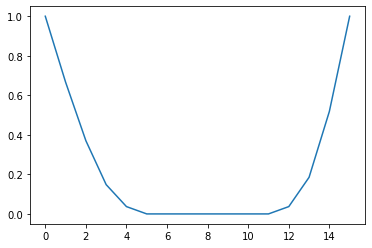

Rutherford County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


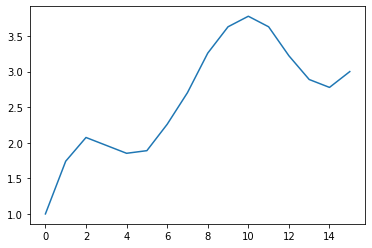

Anson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


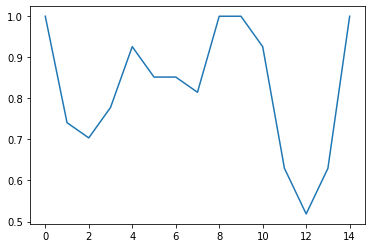

Martin County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


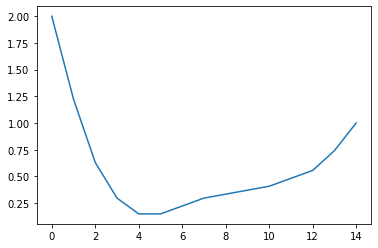

Clay County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


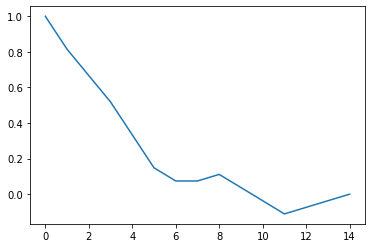

Wilkes County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


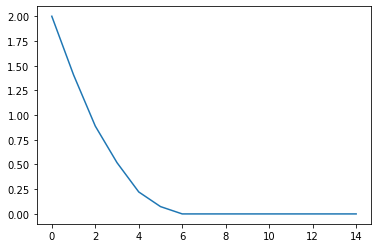

Rockingham County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


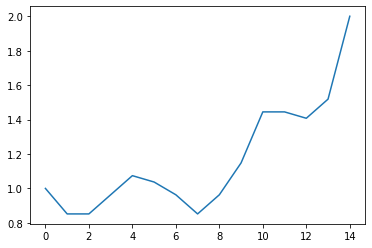

Dare County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


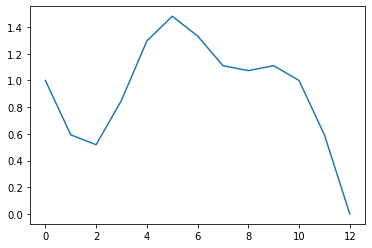

Mitchell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


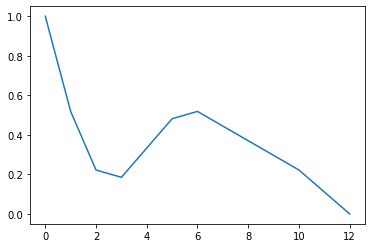

Gates County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


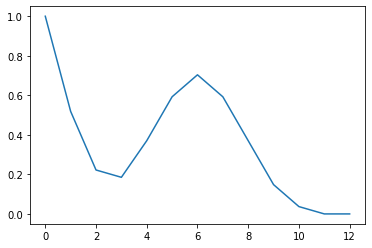

Bladen County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


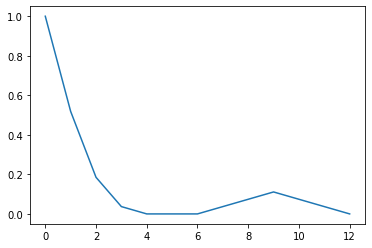

Stokes County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


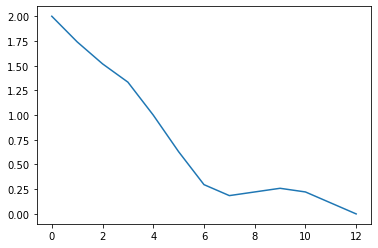

Macon County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


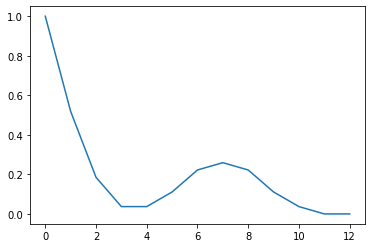

Chowan County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


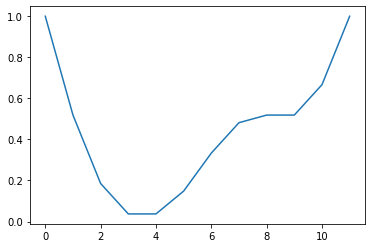

Haywood County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


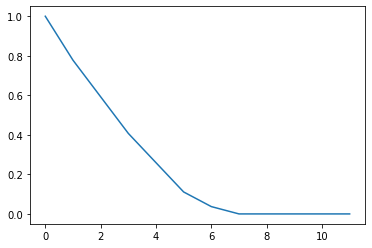

Ashe County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


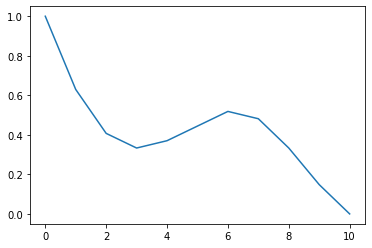

Warren County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


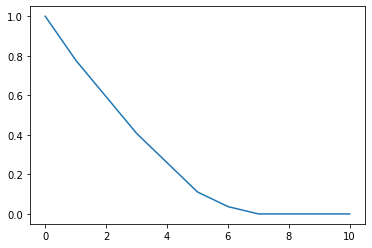

Pender County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


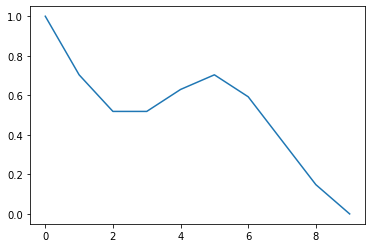

Jackson County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


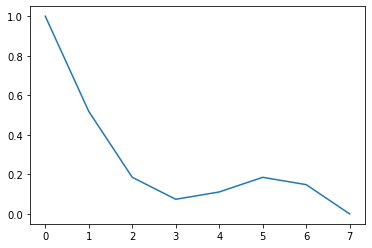

Jones County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


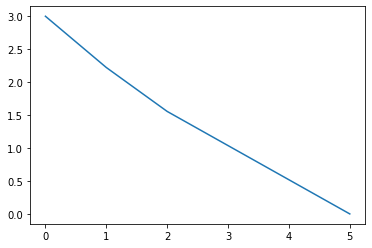

Tyrrell County
Empty DataFrame
Columns: [State, County, First Doubling, Last Delta, Inv Tau, Tau, R Squared, ID]
Index: []


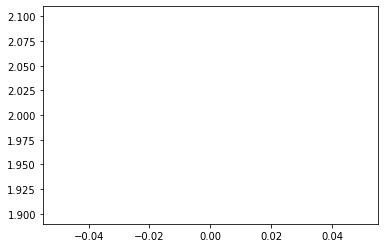

In [27]:
for x in test:
    print(f'{x} County')
    df4 = deriv_df.loc[(deriv_df['County']==x)&(deriv_df['State']==state)]
    print(df4)
    plt.plot(test[x]['xval'],test[x]['deltaIII'])
    plt.show()


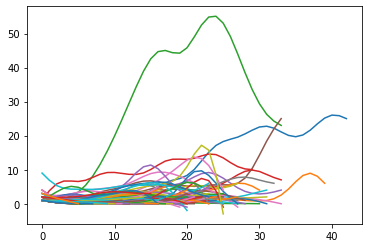

In [28]:
for x in test:
     if len(test[x]['deltaIIIIII']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaIIIIII'])
plt.show()